In [5]:
# Copyright 2019 The TensorFlow Authors All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================

In [6]:
# Visualization of the YAMNet audio event classification model.
# See https://github.com/tensorflow/models/tree/master/research/audioset/yamnet/

In [7]:
# Imports.
import numpy as np
import soundfile as sf

import matplotlib.pyplot as plt

import params
import yamnet as yamnet_model
import tensorflow as tf

In [8]:
# Read in the audio.
# You can get this example waveform via:
# curl -O https://storage.googleapis.com/audioset/speech_whistling2.wav

wav_file_name = 'wav/speech_whistling2.wav'

wav_data, sr = sf.read(wav_file_name, dtype=np.int16)
waveform = wav_data / 32768.0
# The graph is designed for a sampling rate of 16 kHz, but higher rates 
# should work too.
params.SAMPLE_RATE = sr
print("Sample rate =", params.SAMPLE_RATE)

Sample rate = 44100


In [9]:
# Set up the YAMNet model.
class_names = yamnet_model.class_names('yamnet_class_map.csv')
params.PATCH_HOP_SECONDS = 0.1  # 10 Hz scores frame rate.
graph = tf.Graph()
with graph.as_default():
    yamnet = yamnet_model.yamnet_frames_model(params)
    yamnet.load_weights('yamnet.h5')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [10]:
# Run the model.
with graph.as_default():
    scores, spectrogram = yamnet.predict(np.reshape(waveform, [1, -1]), steps=1)

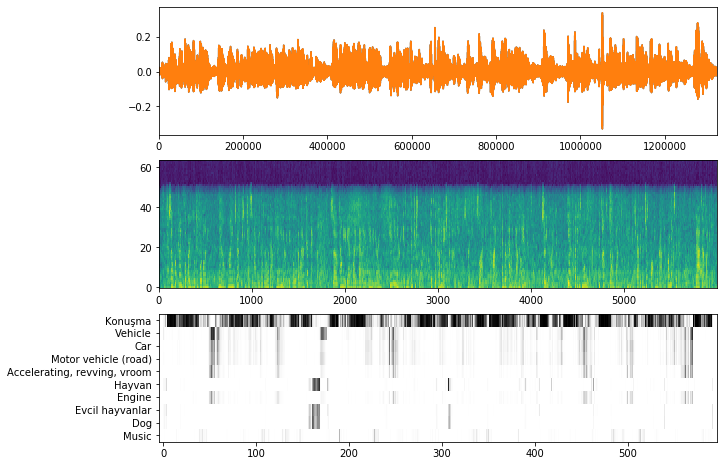

In [11]:
# Visualize the results.
plt.figure(figsize=(10, 8))

# Plot the waveform.
plt.subplot(3, 1, 1)
plt.plot(waveform)
plt.xlim([0, len(waveform)])
# Plot the log-mel spectrogram (returned by the model).
plt.subplot(3, 1, 2)
plt.imshow(spectrogram.T, aspect='auto', interpolation='nearest', origin='bottom')

# Plot and label the model output scores for the top-scoring classes.
mean_scores = np.mean(scores, axis=0)
top_N = 10
top_class_indices = np.argsort(mean_scores)[::-1][:top_N]
plt.subplot(3, 1, 3)
plt.imshow(scores[:, top_class_indices].T, aspect='auto', interpolation='nearest', cmap='gray_r')
# Compensate for the PATCH_WINDOW_SECONDS (0.96 s) context window to align with spectrogram.
patch_padding = (params.PATCH_WINDOW_SECONDS / 2) / params.PATCH_HOP_SECONDS
plt.xlim([-patch_padding, scores.shape[0] + patch_padding])
# Label the top_N classes.
yticks = range(0, top_N, 1)
plt.yticks(yticks, [class_names[top_class_indices[x]] for x in yticks])
_ = plt.ylim(-0.5 + np.array([top_N, 0]))
